In [9]:
!pip install pandas numpy matplotlib seaborn scipy statsmodels

156223.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import ttest_1samp
from statsmodels.stats.anova import AnovaRM

## preparing the forces

In [11]:
D = pd.read_csv('./analysis/efc2_all.csv')
fs = 500
WAIT_EXEC = 3.0
HOLD_DUR = 0.6
sn_list = D.sn.unique()


force1 = []
force2 = []
force3 = []
force4 = []
force5 = []

fGain = [1.0, 1.0, 1.0, 1.5, 1.5]
for sn in sn_list:
    df = D[D.sn == sn]
    mov = pd.read_pickle(f'./analysis/efc2_{sn}_mov.pkl')
    for day in [1,2,3,4,5]:
        df_day = df[df.day == day]
        for BN, TN in zip(df_day.BN, df_day.TN):
            if df_day.loc[(df_day.BN == BN) & (df_day.TN == TN), 'trial_correct'].values[0] == 0:
                force1.append(0)
                force2.append(0)
                force3.append(0)
                force4.append(0)
                force5.append(0)
                continue

            row = (mov.day == day) & (mov.BN == BN) & (mov.TN == TN)
            trial_mov = mov.loc[row, 'mov'].values[0]
            states = trial_mov[:,0]
            forces = trial_mov[states==WAIT_EXEC, -5:] * fGain

            # the hold duration is the last 600ms:
            hold_force = np.mean(forces[-int(HOLD_DUR*fs):, :], axis=0)

            force1.append(hold_force[0])
            force2.append(hold_force[1])
            force3.append(hold_force[2])
            force4.append(hold_force[3])
            force5.append(hold_force[4])

# add the forces to the D:
D['force1'] = force1
D['force2'] = force2
D['force3'] = force3
D['force4'] = force4
D['force5'] = force5

# save D:
D.to_csv('./analysis/efc2_all.csv', index=False)

## Comparing trained force patterns before and after learning

============================ Chord 22911:
                   Anova
             F Value  Num DF  Den DF Pr > F
-------------------------------------------
day            0.7965 1.0000  6.0000 0.4065
fingers     1123.8440 4.0000 24.0000 0.0000
day:fingers    4.0155 4.0000 24.0000 0.0124

     f1: -0.24N, t=-2.19, p=0.072
     f2: 0.26N, t=2.26, p=0.064
     f3: 0.07N, t=0.82, p=0.443
     f4: 0.19N, t=2.10, p=0.081
     f5: -0.11N, t=-1.09, p=0.318


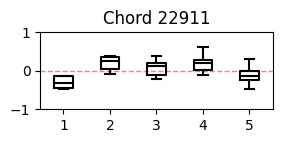

============================ Chord 29212:
                  Anova
            F Value  Num DF  Den DF Pr > F
------------------------------------------
day           4.0482 1.0000  6.0000 0.0909
fingers     882.6377 4.0000 24.0000 0.0000
day:fingers   2.9309 4.0000 24.0000 0.0417

     f1: -0.07N, t=-0.51, p=0.628
     f2: 0.38N, t=5.12, p=0.002
     f3: -0.10N, t=-0.95, p=0.378
     f4: 0.22N, t=1.53, p=0.176
     f5: 0.00N, t=0.04, p=0.970


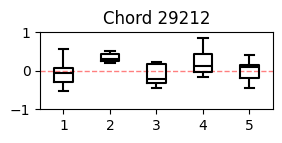

============================ Chord 91211:
                  Anova
            F Value  Num DF  Den DF Pr > F
------------------------------------------
day           0.2437 1.0000  6.0000 0.6391
fingers     674.9905 4.0000 24.0000 0.0000
day:fingers   1.2984 4.0000 24.0000 0.2987

     f1: 0.13N, t=1.52, p=0.180
     f2: -0.00N, t=-0.03, p=0.980
     f3: -0.13N, t=-0.83, p=0.439
     f4: 0.21N, t=4.23, p=0.005
     f5: -0.06N, t=-0.37, p=0.725


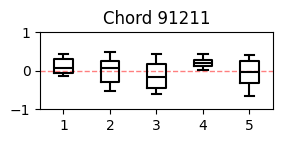

============================ Chord 92122:
                  Anova
            F Value  Num DF  Den DF Pr > F
------------------------------------------
day           0.0012 1.0000  6.0000 0.9732
fingers     758.5408 4.0000 24.0000 0.0000
day:fingers   0.3863 4.0000 24.0000 0.8162

     f1: -0.01N, t=-0.12, p=0.912
     f2: -0.05N, t=-0.20, p=0.851
     f3: 0.15N, t=0.99, p=0.361
     f4: -0.11N, t=-0.79, p=0.458
     f5: 0.03N, t=0.34, p=0.747


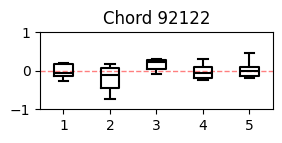

============================ Chord 12129:
                   Anova
             F Value  Num DF  Den DF Pr > F
-------------------------------------------
day            0.0446 1.0000  6.0000 0.8397
fingers     1235.0530 4.0000 24.0000 0.0000
day:fingers    2.6463 4.0000 24.0000 0.0583

     f1: 0.40N, t=2.97, p=0.025
     f2: -0.17N, t=-0.71, p=0.504
     f3: -0.04N, t=-0.26, p=0.803
     f4: -0.16N, t=-1.05, p=0.336
     f5: 0.06N, t=0.54, p=0.606


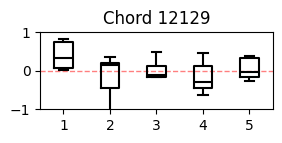

============================ Chord 12291:
                   Anova
             F Value  Num DF  Den DF Pr > F
-------------------------------------------
day           10.4430 1.0000  6.0000 0.0179
fingers     1831.4773 4.0000 24.0000 0.0000
day:fingers    1.7732 4.0000 24.0000 0.1672

     f1: 0.56N, t=4.47, p=0.004
     f2: 0.07N, t=0.30, p=0.778
     f3: 0.22N, t=1.74, p=0.132
     f4: 0.15N, t=1.88, p=0.110
     f5: 0.19N, t=1.46, p=0.195


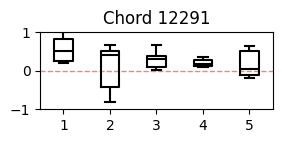

============================ Chord 19111:
                  Anova
            F Value  Num DF  Den DF Pr > F
------------------------------------------
day         170.2999 1.0000  6.0000 0.0000
fingers     296.2451 4.0000 24.0000 0.0000
day:fingers   0.6017 4.0000 24.0000 0.6651

     f1: 0.42N, t=4.13, p=0.006
     f2: 0.25N, t=2.56, p=0.043
     f3: 0.07N, t=0.35, p=0.739
     f4: 0.19N, t=1.40, p=0.210
     f5: 0.16N, t=0.81, p=0.448


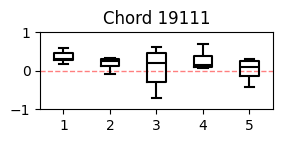

============================ Chord 21291:
                   Anova
             F Value  Num DF  Den DF Pr > F
-------------------------------------------
day            0.4340 1.0000  6.0000 0.5345
fingers     1076.6699 4.0000 24.0000 0.0000
day:fingers    1.1094 4.0000 24.0000 0.3750

     f1: -0.12N, t=-0.73, p=0.490
     f2: 0.05N, t=0.31, p=0.765
     f3: -0.13N, t=-0.72, p=0.498
     f4: 0.19N, t=3.49, p=0.013
     f5: 0.19N, t=1.53, p=0.178


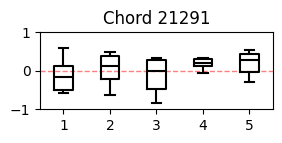

Unchanged chords:
    avg f1: 0.02N
    avg f2: 0.08N
    avg f3: -0.03N
    avg f4: 0.09N
    avg f5: 0.02N
    total avg: 0.04N
Changed chords:
    avg f1: 0.49N
    avg f2: 0.16N
    avg f3: 0.14N
    avg f4: 0.17N
    avg f5: 0.18N
    total avg: 0.23N


In [21]:
D = pd.read_csv('./analysis/efc2_all.csv')
D = D[D.trial_correct==1]

# select trained and day 1 and 5:
D = D[((D.day == 1) | (D.day == 5)) & (D.trained == 1)]
D = D.groupby(['sn', 'day', 'chordID']).agg(
    force1=('force1', 'mean'),
    force2=('force2', 'mean'),
    force3=('force3', 'mean'),
    force4=('force4', 'mean'),
    force5=('force5', 'mean')
).reset_index()

f1_change = []
f2_change = []
f3_change = []
f4_change = []
f5_change = []

chords = D.chordID.unique()
for chord in chords:
    # day = D[D.chordID == chord].day.values
    day1 = (D.chordID == chord) & (D.day == 1)
    day5 = (D.chordID == chord) & (D.day == 5)

    # anovaRM:
    sn_tmp1 = D.loc[day1, 'sn'].values
    day_tmp1 = D.loc[day1, 'day'].values
    f1_tmp1 = D.loc[day1, 'force1'].values
    f2_tmp1 = D.loc[day1, 'force2'].values
    f3_tmp1 = D.loc[day1, 'force3'].values
    f4_tmp1 = D.loc[day1, 'force4'].values
    f5_tmp1 = D.loc[day1, 'force5'].values
    sn_tmp1 = np.tile(sn_tmp1, 5)
    day_tmp1 = np.tile(day_tmp1, 5)
    f_tmp1 = np.concatenate((f1_tmp1, f2_tmp1, f3_tmp1, f4_tmp1, f5_tmp1), axis=0)
    fingers_tmp1 = np.array([1, 2, 3, 4, 5])
    fingers_tmp1 = np.repeat(fingers_tmp1, len(f1_tmp1))

    sn_tmp2 = D.loc[day5, 'sn'].values
    day_tmp2 = D.loc[day5, 'day'].values
    f1_tmp2 = D.loc[day5, 'force1'].values
    f2_tmp2 = D.loc[day5, 'force2'].values
    f3_tmp2 = D.loc[day5, 'force3'].values
    f4_tmp2 = D.loc[day5, 'force4'].values
    f5_tmp2 = D.loc[day5, 'force5'].values
    sn_tmp2 = np.tile(sn_tmp2, 5)
    day_tmp2 = np.tile(day_tmp2, 5)
    f_tmp2 = np.concatenate((f1_tmp2, f2_tmp2, f3_tmp2, f4_tmp2, f5_tmp2), axis=0)
    fingers_tmp2 = np.array([1, 2, 3, 4, 5])
    fingers_tmp2 = np.repeat(fingers_tmp2, len(f1_tmp2))

    sn_tmp = np.concatenate((sn_tmp1, sn_tmp2), axis=0)
    day_tmp = np.concatenate((day_tmp1, day_tmp2), axis=0)
    f_tmp = np.concatenate((f_tmp1, f_tmp2), axis=0)
    fingers_tmp = np.concatenate((fingers_tmp1, fingers_tmp2), axis=0)
    df = pd.DataFrame({'sn': sn_tmp, 'day': day_tmp, 'force': f_tmp, 'fingers': fingers_tmp})
    table = AnovaRM(data=df, depvar='force', subject='sn', within=['day','fingers'])
    res = table.fit()
    print(f'============================ Chord {chord}:')
    print(res)

    f1 = D.loc[day5, 'force1'].values - D.loc[day1, 'force1'].values
    f2 = D.loc[day5, 'force2'].values - D.loc[day1, 'force2'].values
    f3 = D.loc[day5, 'force3'].values - D.loc[day1, 'force3'].values
    f4 = D.loc[day5, 'force4'].values - D.loc[day1, 'force4'].values
    f5 = D.loc[day5, 'force5'].values - D.loc[day1, 'force5'].values
    f1_change.append(f1.mean())
    f2_change.append(f2.mean())
    f3_change.append(f3.mean())
    f4_change.append(f4.mean())
    f5_change.append(f5.mean())
    
    # ttest:
    t1, p1 = ttest_1samp(f1, 0)
    t2, p2 = ttest_1samp(f2, 0)
    t3, p3 = ttest_1samp(f3, 0)
    t4, p4 = ttest_1samp(f4, 0)
    t5, p5 = ttest_1samp(f5, 0)
    print(f'     f1: {f1.mean():.2f}N, t={t1:.2f}, p={p1:.3f}')
    print(f'     f2: {f2.mean():.2f}N, t={t2:.2f}, p={p2:.3f}')
    print(f'     f3: {f3.mean():.2f}N, t={t3:.2f}, p={p3:.3f}')
    print(f'     f4: {f4.mean():.2f}N, t={t4:.2f}, p={p4:.3f}')
    print(f'     f5: {f5.mean():.2f}N, t={t5:.2f}, p={p5:.3f}')

    forces = np.concatenate((f1, f2, f3, f4, f5), axis=0)
    fingers = np.array([1, 2, 3, 4, 5])
    fingers = np.repeat(fingers, len(f1))

    fig, ax = plt.subplots(1, 1, figsize=(3, 1))
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)
    sns.boxplot(x=fingers, y=forces, ax=ax, width=0.4, fliersize=0, color='k', fill=False)
    plt.ylim((-1, 1))
    plt.title(f'Chord {chord}')
    plt.show()

f1_change = np.array(f1_change)
f2_change = np.array(f2_change)
f3_change = np.array(f3_change)
f4_change = np.array(f4_change)
f5_change = np.array(f5_change)
# changed chprds:
print('Unchanged chords:')
print(f'    avg f1: {np.mean(f1_change[[0,1,2,3,4,7]]):.2f}N')
print(f'    avg f2: {np.mean(f2_change[[0,1,2,3,4,7]]):.2f}N')
print(f'    avg f3: {np.mean(f3_change[[0,1,2,3,4,7]]):.2f}N')
print(f'    avg f4: {np.mean(f4_change[[0,1,2,3,4,7]]):.2f}N')
print(f'    avg f5: {np.mean(f5_change[[0,1,2,3,4,7]]):.2f}N')
print(f'    total avg: {np.mean(f1_change[[0,1,2,3,4,7]]/5 + f2_change[[0,1,2,3,4,7]]/5 + f3_change[[0,1,2,3,4,7]]/5 + f4_change[[0,1,2,3,4,7]]/5 + f5_change[[0,1,2,3,4,7]]/5):.2f}N')

print('Changed chords:')
print(f'    avg f1: {np.mean(f1_change[[5,6]]):.2f}N')
print(f'    avg f2: {np.mean(f2_change[[5,6]]):.2f}N')
print(f'    avg f3: {np.mean(f3_change[[5,6]]):.2f}N')
print(f'    avg f4: {np.mean(f4_change[[5,6]]):.2f}N')
print(f'    avg f5: {np.mean(f5_change[[5,6]]):.2f}N')
print(f'    total avg: {np.mean(f1_change[[5,6]]/5 + f2_change[[5,6]]/5 + f3_change[[5,6]]/5 + f4_change[[5,6]]/5 + f5_change[[5,6]]/5):.2f}N')
